In [7]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

In [8]:
vector.register_awkward() 

In [9]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [10]:
!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0   132k      0  0:12:53  0:12:53 --:--:-- 1450k  0  0:21:06  0:00:18  0:20:48  104k 108k      0  0:15:50  0:00:59  0:14:51  110k3k      0  0:15:05  0:01:28  0:13:37  127k0   120k      0  0:14:12  0:06:42  0:07:30 92578   120k      0  0:14:15  0:07:02  0:07:13  114k  0     0   116k      0  0:14:44  0:09:21  0:05:23  112k   116k      0  0:14:44  0:09:22  0:05:22  111k     0   116k      0  0:14:44  0:09:33  0:05:11  103k    0  0:15:02  0:10:53  0:04:09 56166


In [6]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run290223.mc.root:   ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)


OSError: expected Chunk of length 153,
received 0 bytes from MemmapSource
for file path run291694.data.root

In [5]:
n=0
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge","Muon_E"],how="zip",step_size=10000):
    #Nombre d'évènements avec au moins 2 muons pour chaque lot de 10000 évènements
    #print(len(m),len(m[ak.where(m.nMuons>1)])) 
    n+=len(m[ak.where(m.nMuons>1)])
print("Nombre total d'évènements avec au moins 2 muons : ",n)

Nombre total d'évènements avec au moins 2 muons :  109729


In [6]:
#Calcul de la norme des quantités de mouvement d'un évènement
"""{
def vmag(px,py,pz):
    #Returns an array of the norms of the 3-vectors (px,py,pz).
    return np.sqrt(px*px+py*py+pz*pz) #tableau avec la même dimension que le nombre de muons de l'évènement
}"""

In [7]:
"""{
%time
#Tous les évènements avec au moins 2 muons
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge","Muon_E"],step_size=10000):
    atLeastTwoMuon = m.nMuons>1
    t = m[atLeastTwoMuon]
    mag = vmag(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])
    muonCharge = t["Muon_Charge"]
    muonEnergy = t["Muon_E"]
print(mag[1])
print(muonCharge[1])
print(muonEnergy[1])
}"""

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 18.6 µs
[3.07, 10.1]
[1, -1]
[3.07, 10.1]


In [8]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [9]:
"""{
%time
#Tous les évènements avec 3 muons
def Charge3(muonCharge,i):
    if muonCharge3[i][0] == muonCharge3[i][1] and muonCharge3[i][0] == muonCharge3[i][2]:
        return True
    else : 
        return False
}"""


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [10]:
"""{
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge","Muon_E"],step_size=10000):
    threeMuon = m.nMuons==3
    t3=m[threeMuon] #Tous les évènements avec 3 muons pour chaque lot de 10000 évènements
    #print(len(m),len(t3))
    muonCharge3 = t3["Muon_Charge"]
    #print(muonCharge3[1:3])
    #for i in range(0,step_size):
    #    if Charge3(muonCharge3,i)==False:
            
}""""

In [1]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events)
        goodTracks=tracks[trackSelector(tracks)]
        
        pairs = ak.combinations(goodTracks, 2)
        one, two = ak.unzip(pairs)
        
        opposite_charge_cut = one.charge + two.charge == 0
        
        quality_one = one[opposite_charge_cut]
        quality_two = two[opposite_charge_cut]
        invariant_mass = (quality_one + quality_two).mass
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi)) 
        hInvMass.fill(ak.flatten(invariant_mass))


        if verbose:
            print(batch[1])
            


NameError: name 'hist' is not defined

In [12]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass'))

scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hInvMass=vhInvMass)

scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hInvMass=vhInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9)) # & x["matched"]==2)

CPU times: user 5.93 s, sys: 215 ms, total: 6.15 s
Wall time: 6.22 s


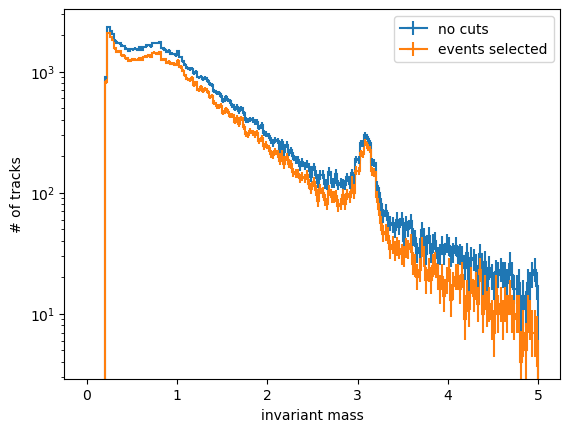

CPU times: user 822 ms, sys: 140 ms, total: 962 ms
Wall time: 760 ms


In [86]:
%%time
vhInvMass.plot(label="no cuts")
vhInvMassEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.legend()
plt.show()

In [7]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

vector.register_awkward() 

DATATYPE="mc"
BASEDIR="."

!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/nbPmKbcsJvZrjjx/291694/AnalysisResults.root' > run291694.mc.root
!file *.root
file = uproot.open("run291694.mc.root")
file.keys()
events = file["eventsTree"]
gen = file["genTree"]

def getTracks(events, gen):
    print("a")
    print(
                "px",events["Muon_Px"], "\n",
                "py",events["Muon_Py"], "\n",
                "pz",events["Muon_Pz"], "\n",
                "E",events["Muon_E"], "\n",
                "charge",events["Muon_Charge"], "\n",
                "thetaAbs",events["Muon_thetaAbs"], "\n",
                "matched",events["Muon_matchedTrgThreshold"], "\n",
                "GenPx",gen["Muon_GenPx"], "\n",
                "GenPy",gen["Muon_GenPy"], "\n",
                "GenPz",gen["Muon_GenPz"], "\n",
                "GenE",gen["Muon_GenE"], "\n",
                "GenMotherPDGCode",gen["Muon_GenMotherPDGCode"])
    return ak.zip({"px":events["Muon_Px"],
                    "py":events["Muon_Py"],
                    "pz":events["Muon_Pz"],
                    "E":events["Muon_E"],
                    "charge":events["Muon_Charge"],
                    "thetaAbs":events["Muon_thetaAbs"],
                    "matched":events["Muon_matchedTrgThreshold"],
                  "GenPx":gen["Muon_GenPx"],
                   "GenPy":gen["Muon_GenPy"],
                   "GenPz":gen["Muon_GenPz"],
                   "GenE":gen["Muon_GenE"],
                   "GenMotherPDGCode":gen["Muon_GenMotherPDGCode"]},
                    with_name='Momentum4D')

def scan(dataDescription1, dataDescription2, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
vec = getTracks(events, gen)

print(vec)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6915k  100 6915k    0     0  1253k      0  0:00:05  0:00:05 --:--:-- 1664k
run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
a
px <TBranchElement 'Muon_Px' at 0x7ff07cce59f0> 
 py <TBranchElement 'Muon_Py' at 0x7ff07ccc24d0> 
 pz <TBranchElement 'Muon_Pz' at 0x7ff07ccc11b0> 
 E <TBranchElement 'Muon_E' at 0x7ff07cce6dd0> 
 charge <TBranchElement 'Muon_Charge' at 0x7ff07ccc3c10> 
 thetaAbs <TBranchElement 'Muon_thetaAbs' at 0x7ff07ccc2b30> 
 matched <TBranchElement 'Muon_matchedTrgThreshold' at 0x7ff07cd6c820> 
 GenPx <TBranchElement 'Muon_GenPx' at 0x7ff07ae2bdc0> 
 GenPy <TBranchElement 'Muon_GenPy' at 0x7ff07adf0760> 
 GenPz <TBranchElement 'Muon_GenPz' at 0x7ff07adf10c0> 
 GenE <TBranchElem

[{nMuons: 2, isCINT: True, isCMUL: False, isCMSL: True, ... 2, 0]}] 
 [{nMuonsGen: 2, Muon_GenE: [10.3, 20.7], ... Muon_GenMotherPDGCode: [443, 443]}] 

[[], [], [], [], [], [], ... E: 11.7, charge: -1, thetaAbs: 5.79, matched: 0})]]
a
A x ε = 23.98 \%


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efefbe379d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

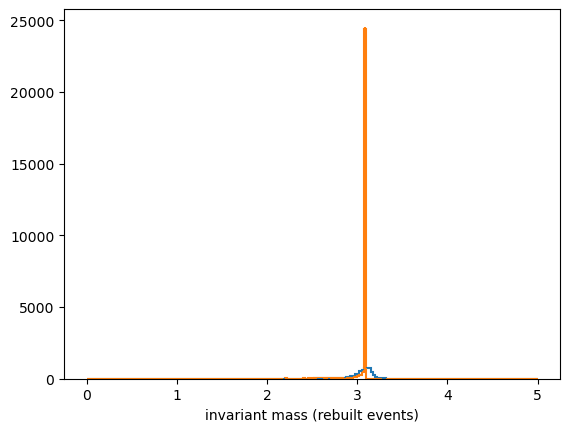

In [45]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

vector.register_awkward() 

DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/nbPmKbcsJvZrjjx/291694/AnalysisResults.root' > run291694.mc.root
#!file *.root
#file = uproot.open("run291694.mc.root")
#file.keys()
#events = file["eventsTree"]
#gen = file["genTree"]

#def data_url(run,is_mc):
#    basesrc="https://cernbox.cern.ch/remote.php/dav/public-files/VJZ5whMyF5Kxldd/dimuonData_LHC18m"
#    if is_mc==True:
#        basesrc+="MC"
#    return f"{basesrc}/{run}/AnalysisResults.root"

#def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
#    datatype="mc" if is_mc else "data"
#    print({dest},"/run",{run},".",{datatype},".root")
#    return f"{dest}/run{run}.{datatype}.root"

#def copy_cmd(run,is_mc,dest):
#    return f"curl '{data_url(run,is_mc)}' > {data_file_path(run,is_mc,dest)}"

def getTracks(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def getTracksGenerated(gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracksGen = gen[j]
    return ak.zip({ "px":tracksGen["Muon_GenPx"],
                   "py":tracksGen["Muon_GenPy"],
                   "pz":tracksGen["Muon_GenPz"],
                   "E":tracksGen["Muon_GenE"],
                   "GenMotherPDGCode":tracksGen["Muon_GenMotherPDGCode"]},
                    with_name='Momentum4D')

def scan(dataDescription1, dataDescription2, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMass:hist.Hist, hInvMassGen:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch1, batch2 in zip(uproot.iterate(dataDescription1,
                                ["nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True), 
                             uproot.iterate(dataDescription2,
                                ["nMuonsGen", "Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 step_size="100 MB", report=True)):
        events=batch1[0] # batch[1] is the report info
        gen=batch2[0]
        print(events, "\n", gen, "\n")
        if len(events) < 1000:
            print("something is wrong",batch1[1], batch2[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events, gen)
        
        tracksGen = getTracksGenerated(gen)
        
        # Cut
        goodTracks = tracks[trackSelector(tracks)]
        
        pairs = ak.combinations(goodTracks, 2)
        pairsGen = ak.combinations(tracksGen, 2)
        
        # Pair Creations
        one, two = ak.unzip(pairs)
        oneGen, twoGen = ak.unzip(pairsGen)
        
        # Charge cut for Rebuilt Events
        opposite_charge_cut = one.charge + two.charge == 0
        
        # Inv Mass of Rebuilt Events
        quality_one = one[opposite_charge_cut]
        quality_two = two[opposite_charge_cut]
        invariant_mass = (quality_one + quality_two).mass
        invariant_massGen = (oneGen + twoGen).mass
        
        # Filling Histograms
        hMag.fill(ak.flatten(tracks.p))
        hPhi.fill(ak.flatten(tracks.phi)) 
        hInvMass.fill(ak.flatten(invariant_mass))
        hInvMassGen.fill(ak.flatten(invariant_massGen))

        print(pairs)
        print("a")

        if verbose:
            print(batch1[1], "\n", batch2[1])

vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMass = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass (rebuilt events)'))
vhInvMassGen = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=5,name='invariant mass (generated events)'))

scan(dataDescription1=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
     dataDescription2=f"{BASEDIR}/run291694.{DATATYPE}.root:genTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hInvMass=vhInvMass, hInvMassGen = vhInvMassGen,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<10))

nRebuilt = vhInvMass.sum()
nGen = vhInvMassGen.sum()
print("A x \u03B5 = %.2f" %((nRebuilt/nGen)*100), "%")

vhInvMass.plot(label="Rebuilt events")
vhInvMassGen.plot(label="Generated events")